# **Resultado móvil de la balanza energética**

---



El presente archivo contiene el código utilizado para obtener, procesar y analizar los datos correspondientes al Balance Cambiario, publicado mensualmente por el Banco Central de la República Argentina (BCRA).

El Balance Cambiario recoge datos de las compras y ventas de moneda extranjera realizadas en el mercado de cambios formal. Se subdivide en numerosas aperturas, que dan cuenta de la multiplicidad de actividades económicas. En particular, se analizará la evolución de 3 partidas: electricidad, gas y petróleo.

Como resultado del análisis, se presenta una figura en forma de gráfico de línea rellena (área bajo/sobre línea) que permite visualizar los períodos y niveles de superávit/déficit del balance cambiario-energético.

## Preliminar

### Importación de *libraries*

Se importan las *libraries* a utilizar en el código.

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
import datetime as dt
from datetime import date

### Exportación a archivo `.pdf`

En caso de precisarse exportar las figuras resultantes a formato `.pdf`, se debe instalar el *package* `kaleido`.

**IMPORTANTE**: para evitar problemas de desconexión, es recomendable ejecutar el código la siguiente celda y, una vez terminado el proceso de instalación, reiniciar el entorno de ejecución y ejecutar todas las celdas.

In [2]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.3 MB/s eta 0:00:00


## Resultado móvil de la balanza energética

### Obtención de datos

Los datos del balance cambiario son publicados mensualmente por el Banco Central de la República Argentina (BCRA), en el Informe de la Evolución del Mercado de Cambios y Balance Cambiario.

En conjunto con dicho informe, es publicado el Anexo estadístico del balance cambiario, que contiene un desglose de todas las operaciones de cambio, desagregadas por apertura.

El link `url_balance` refiere a dicho archivo.

In [3]:
url_balance = "https://www.bcra.gob.ar/Pdfs/PublicacionesEstadisticas/Anexo.xlsm"

En el Anexo estadístico, cada apertura (sector económico) es representado por un código, compuesto por "mcsec" y un número de 3 cifras.

En particular, son de relevancia las columnas:
*   "Mes": `mcsec000`
*   "Electricidad (Generación, Transporte, Distribución)": `mcsec008`
*   "Gas (Extracción, Transporte, Distribución)": `mcsec011`
*   "Petróleo": `mcsec024`

Estos códigos se encuentran agrupados en la lista `cols`.

In [4]:
col_ends = ["000", "008", "011", "024"]
cols = []
for end in col_ends:
  cols.append("mcsec"+end)

A partir de `url_balance` y las columnas agrupadas en `cols`, se utiliza la *library* `pandas` para leer la hoja "Mercado de Camb. - Por sector" del archivo, ignorando las primeras 25 filas y utilizando solo las columnas deseadas.

In [5]:
balance = pd.read_excel(url_balance, sheet_name="Mercado de Camb. - Por sector", skiprows=25, usecols=cols).drop([0]).reset_index(drop=True)

### *Data Cleaning*

Por motivos de simpleza, se renombran las columnas.

In [6]:
balance = balance.rename(
  columns={
    cols[0]: "Período",
    cols[1]: "Electricidad",
    cols[2]: "Gas",
    cols[3]: "Petróleo"
  })

Para crear el índice temporal (columna "Período"), debe -primeramente- ser interpretada como un número entero (`.astype(int)`) y -luego- convertirla en formato `datetime`(`pd.to_datetime()`) como cadena de texto (`.astype(str)`), aplicándole el formato correspondiente.

In [7]:
balance['Período'] =balance['Período'].astype(int)

In [8]:
balance['Período'] = pd.to_datetime(balance['Período'].astype(str), format='%Y%m')

Los datos de electricidad, gas y petróleo se suman en una sola columna, "Total Energía".

In [9]:
balance['Total Energía'] = balance['Electricidad'] + balance['Gas'] + balance['Petróleo']

Sobre dicha columna, se calcula la media móvil anual (ventana de 12 meses) mediante el comando `.rolling(12)`.

In [10]:
balance['RAvg_12m'] = balance['Total Energía'].rolling(12).sum()

### DataFrame final

Se eliminan las columnas innecesarias.

In [11]:
balance = balance[['Período', 'RAvg_12m']]

Así, queda creado el *DataFrame* que contiene el índice temporal y la media móvil anual.

A continuación, se presentan las primeras 5 filas de dicho *DataFrame*.

In [12]:
balance.head()

,Período,RAvg_12m
0,2003-01-01,NaN
1,2003-02-01,NaN
2,2003-03-01,NaN
3,2003-04-01,NaN
4,2003-05-01,NaN


Nótese que, por la ventana de 12 meses, las primeras 5 filas arrojan `NaN`. Sin embargo, las últimas 5 filas sí muestran valores correctos.

In [13]:
balance.tail()

,Período,RAvg_12m
236,2022-09-01,-8219.6261
237,2022-10-01,-8349.4315
238,2022-11-01,-8243.1935
239,2022-12-01,-8382.3469
240,2023-01-01,-8510.0076


Por último, se exporta el *DataFrame* en formato `.xlsx`.

In [14]:
balance.to_excel("Resultado móvil de la balanza energética.xlsx", index=False)

## Figura: Resultado móvil de la balanza energética

El resultado acumulado móvil anual puede indicar un superávit (generalmente representado con el color verde) o un déficit (color rojo), para cada mes del año. Se definen, así, los colores.

In [15]:
green = "#66AA00"
red = "#B82E2E"

Para facilitar la visualización, es necesario agregar dos columnas al *DataFrame* original: la primera, "superavit", toma el valor del resultado acumulado móvil cuando el balance toma valores positivos; la segunda, "deficit", hace lo mismo para los valores negativos de la serie.

In [16]:
balance['superavit'] = balance["RAvg_12m"].where(balance["RAvg_12m"] > 0)
balance['deficit'] = balance["RAvg_12m"].where(balance["RAvg_12m"] < 0)

<ipython-input-16-99bc3594d3ce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balance['superavit'] = balance["RAvg_12m"].where(balance["RAvg_12m"] > 0)
<ipython-input-16-99bc3594d3ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balance['deficit'] = balance["RAvg_12m"].where(balance["RAvg_12m"] < 0)


Se crea la figura `balance_fig` en el entorno de Plotly (utilizando `graph_objects` como `go`).

In [17]:
balance_fig = go.Figure()

Al tratarse de una sola figura, en este caso, no se define una función, sino que las especificaciones de la figura se encuentran en el argumento de ésta.

In [18]:
for column, color in zip(balance.columns[2:], [green, red]):
  balance_fig.add_trace(
    go.Scatter(
    showlegend=False,
    mode='lines',
    name=column,
    x=balance[balance.columns[0]],
    y=balance[column],
    line=dict(color=color),
    fill='tozeroy')
    )

balance_fig.add_trace(
  go.Scatter(
    mode='lines',
    showlegend=True,
    name="Resultado acumulado móvil - 12 meses",
    x=[dt.date(2001, 3, 30), dt.date(2002, 3, 30)],
    y=[0, 1],
    marker=dict(color="lightgray")))


balance_fig.add_trace(
  go.Scatter(
    showlegend=False,
    x=balance[balance.columns[0]].tail(1),
    y=balance["RAvg_12m"].tail(1),
    mode='markers',
    marker=dict(color=red, size=10),
    name=" - EoP"
    )
)

balance_fig.add_annotation(
  x=balance[balance.columns[0]][len(balance)-1],
  y=balance["RAvg_12m"][-1:].values[0],
  text=round(balance["RAvg_12m"][-1:].values[0], 2).astype(str),
  font=dict(color=red),
  xanchor="left",
  xshift=7.5,
  yshift=0,
  showarrow=False
  )

balance_fig = balance_fig.update_layout(
    margin=dict(b=15, t=15, l=15, r=60),
    height=750, 
    width=1000, 
    yaxis_title="<b>M USD",
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(
        orientation='h',
        xanchor='center', 
        x=0.5, 
        yanchor='bottom', 
        y=1,
        font=dict(size=16)
        ),
    xaxis=dict(
        range=[balance[balance.columns[0]][0], dt.date(date.today().year, date.today().month, 1)],
        tickformat="%m<br><b>%Y", dtick="M12",
        ),
    yaxis=dict(
        dtick="1000",
        showgrid=True,
        gridcolor="lightgray",
        zeroline=True,
        zerolinewidth=1,
        zerolinecolor="gray"
        ),
    font=dict(
        size=14,
        family="Serif"
        )
    )

A continuación, se exhibe la figura.

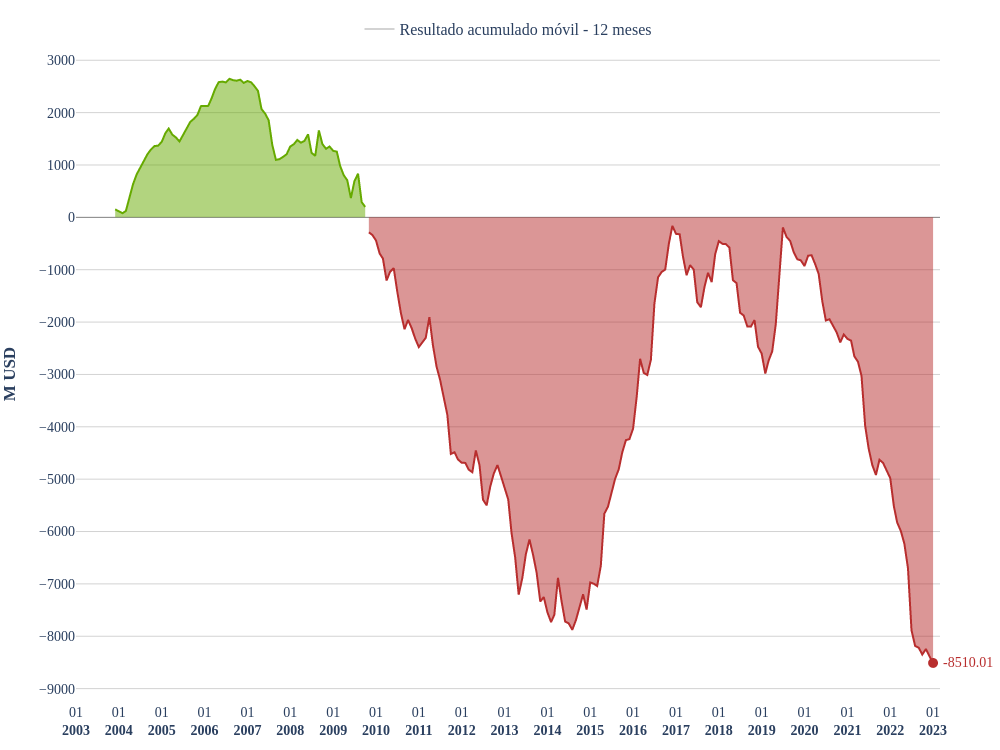

In [19]:
balance_fig.show("png")

Si se desea exportar la figura a formato `.pdf`, se debe des-comentar y ejecutar la siguiente celda. Recuérdese que el *package* `kaleido` debe estar correctamente instalado.

In [20]:
pio.write_image(balance_fig, "Figura Balance Energetico (acum. anual).pdf", width=3*300, height=2.25*300)